# Hyperparameters

| hyperparameter|ESOL|FP|AIT|FLVL|FLVU|HCOM|
|--------------:|---:|-:|--:|---:|---:|---:|
| hidden_size | 91 | 84 | 65 | 63 | 68 | 64 |
| dropout | 0.282 | 0.360 | 0.266 | 0.362 | 0.335 | 0.435 |
| num_layers | 2 | 4 | 4 | 3 | 2 | 4 |
| num_timesteps | 4 | 4 | 4 | 3 | 3 | 4 |
| lr_init | 0.01 | 0.01 | 0.01 | 0.01 | 0.001 | 0.01 |
| gamma | 0.980 | 0.994 | 0.995 | 0.982 | 0.995 | 0.995 |
| weight_decay | 6.0 $\times$ 10$^{-5}$ | 3.5 $\times$ 10$^{-3}$ | 1.8 $\times$ 10$^{-3}$ | 1.3 $\times$ 10$^{-2}$ | 1.2 $\times$ 10$^{-3}$ | 2.7 $\times$ 10$^{-3}$ |

# Parameter Setting

In [1]:
SMILES = "O=C(c1ccccc1)OCCOCCOC(=O)c1ccccc1"; TRUE_VAL = 10

parameters = dict(
    subfrag_size = 12,
    edge_size = 3,
    out_size = 1,
    seed = 42,
    batch_size = 256,
    max_epoch = 200,
    verbose = True,
    save = False,
    
    target = 'FP',
    hidden_size = 84,
    dropout = 0.360,
    num_layers = 4,
    num_timesteps = 4,
    lr_init = 0.01,
    gamma = 0.994,
    weight_decay = 3.5E-3,
)

DATAPATH = "/SSD2/bgkang/Chemomile"
MODELPATH = "../Model/FP-2024-06-12-06-14-47"
# MODELPATH = "../Model/AIT-2024-06-12-06-39-26"
# MODELPATH = "../Model/HCOM-2024-06-12-07-04-08"
# MODELPATH = "../Model/FLVL-2024-06-12-06-43-19"
# MODELPATH = "../Model/FLVU-2024-06-12-06-59-13"

# Serotonin
# SMILES = "C1=CC2=C(C=C1O)C(=CN2)CCN"; TRUE_VAL = 205.4 + 273.15
# Cinnamaldehyde
# SMILES = "O=CC=Cc1ccccc1"; TRUE_VAL = 71 + 273.15
# 1,1'-(1,3-Phenylene)bis(1H-pyrrole-2,5-dione)
# SMILES = "CC1=CC(=O)N(C1=O)CC2=CC(=CC=C2)CN3C(=O)C=C(C3=O)C"; TRUE_VAL = 250.7 + 273.15
# Adrenosterone
# SMILES = "CC12CCC(=O)C=C1CCC3C2C(=O)CC4(C3CCC4=O)C"; TRUE_VAL = 206.0 + 273.15

# 4-Nitrotoluene
# SMILES = "O=[N+]([O-])c1ccc(C)cc1"; TRUE_VAL = 379 # FP
# SMILES = "O=[N+]([O-])c1ccc(C)cc1"; TRUE_VAL = 1.6 # FLVL

SYMBOL = dict([(1, "H"), (6, "C"), (8, "O"), (7, "N"), (0, "*")]) # Atomic Symbol

# Prediction

In [2]:
import sys
sys.path.append(DATAPATH)
import numpy as np
import torch
import matplotlib.pyplot as plt
import networkx as nx

from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_networkx

from src.data import Dataset
from src.smiles2data import smiles2data
from src.model import Chemomile
from src.explainer import Explainer

In [3]:
dataset = Dataset(target = parameters['target'],
                  root = DATAPATH)
data = smiles2data(SMILES, TRUE_VAL)

model = Chemomile(
            subfrag_size = parameters['subfrag_size'],
            hidden_size = parameters['hidden_size'],
            out_size = parameters['out_size'],
            edge_size = parameters['edge_size'],
            dropout = parameters['dropout'],
            num_layers = parameters['num_layers'],
            num_timesteps = parameters['num_timesteps'],
            )
model.load_state_dict(torch.load(MODELPATH))
model.eval()

	DataDump found for 'FP'. Loading dumped data.
Training : 768 | Validation : 96 | Test : 96
Total : 960


RuntimeError: Error(s) in loading state_dict for Chemomile:
	Missing key(s) in state_dict: "atom_encoder.0.weight", "atom_encoder.0.bias", "atom_encoder.1.weight", "atom_encoder.1.bias", "atom_encoder.1.running_mean", "atom_encoder.1.running_var", "fully_connected.3.running_mean", "fully_connected.3.running_var", "fully_connected.4.weight", "fully_connected.4.bias". 
	size mismatch for subfrag_level.lin1.weight: copying a param with shape torch.Size([168, 12]) from checkpoint, the shape in current model is torch.Size([168, 84]).
	size mismatch for molecule_level.lin1.weight: copying a param with shape torch.Size([168, 12]) from checkpoint, the shape in current model is torch.Size([168, 84]).
	size mismatch for fully_connected.3.weight: copying a param with shape torch.Size([1, 84]) from checkpoint, the shape in current model is torch.Size([84]).
	size mismatch for fully_connected.3.bias: copying a param with shape torch.Size([1]) from checkpoint, the shape in current model is torch.Size([84]).

In [4]:
explainer = Explainer(
    model = model,
    data = data
)

pred = explainer.ref * dataset.std + dataset.mean

nameset = [data.smiles for data in dataset.total_set]

if SMILES in nameset:
    print(f"{SMILES} is already in the dataset.")
print(f"| SMILES : {data.smiles} | TRUE : {data.y:.3f} | PRED : {pred:.3f} |")

O=C(c1ccccc1)OCCOCCOC(=O)c1ccccc1 is already in the dataset.
| SMILES : O=C(c1ccccc1)OCCOCCOC(=O)c1ccccc1 | TRUE : 10.000 | PRED : 502.511 |


# Explain

In [5]:
score = explainer.atomMask()
score

[-0.123809814453125,
 -0.11659598350524902,
 -0.004718303680419922,
 -0.015233278274536133,
 -0.013939619064331055,
 -0.014831066131591797,
 -0.015223979949951172,
 -0.016658782958984375,
 -0.14638185501098633,
 -0.008195638656616211,
 0.003239870071411133,
 -0.1715688705444336,
 0.003668546676635742,
 -0.0012600421905517578,
 -0.15161705017089844,
 -0.11571836471557617,
 -0.12848424911499023,
 0.020830392837524414,
 0.0022172927856445312,
 0.010472297668457031,
 0.011799097061157227,
 0.01094365119934082,
 0.006173849105834961,
 -0.012966156005859375,
 -0.013958215713500977,
 -0.015645980834960938,
 -0.015491247177124023,
 -0.013958930969238281,
 -0.0030472278594970703,
 -0.002898693084716797,
 -0.0021724700927734375,
 -0.002447843551635742,
 -0.002042531967163086,
 -0.002329587936401367,
 -0.002359151840209961,
 -0.002474546432495117,
 -0.01466822624206543,
 -0.0132293701171875,
 -0.011968612670898438,
 -0.012439250946044922,
 -0.01454472541809082]

# Visualization

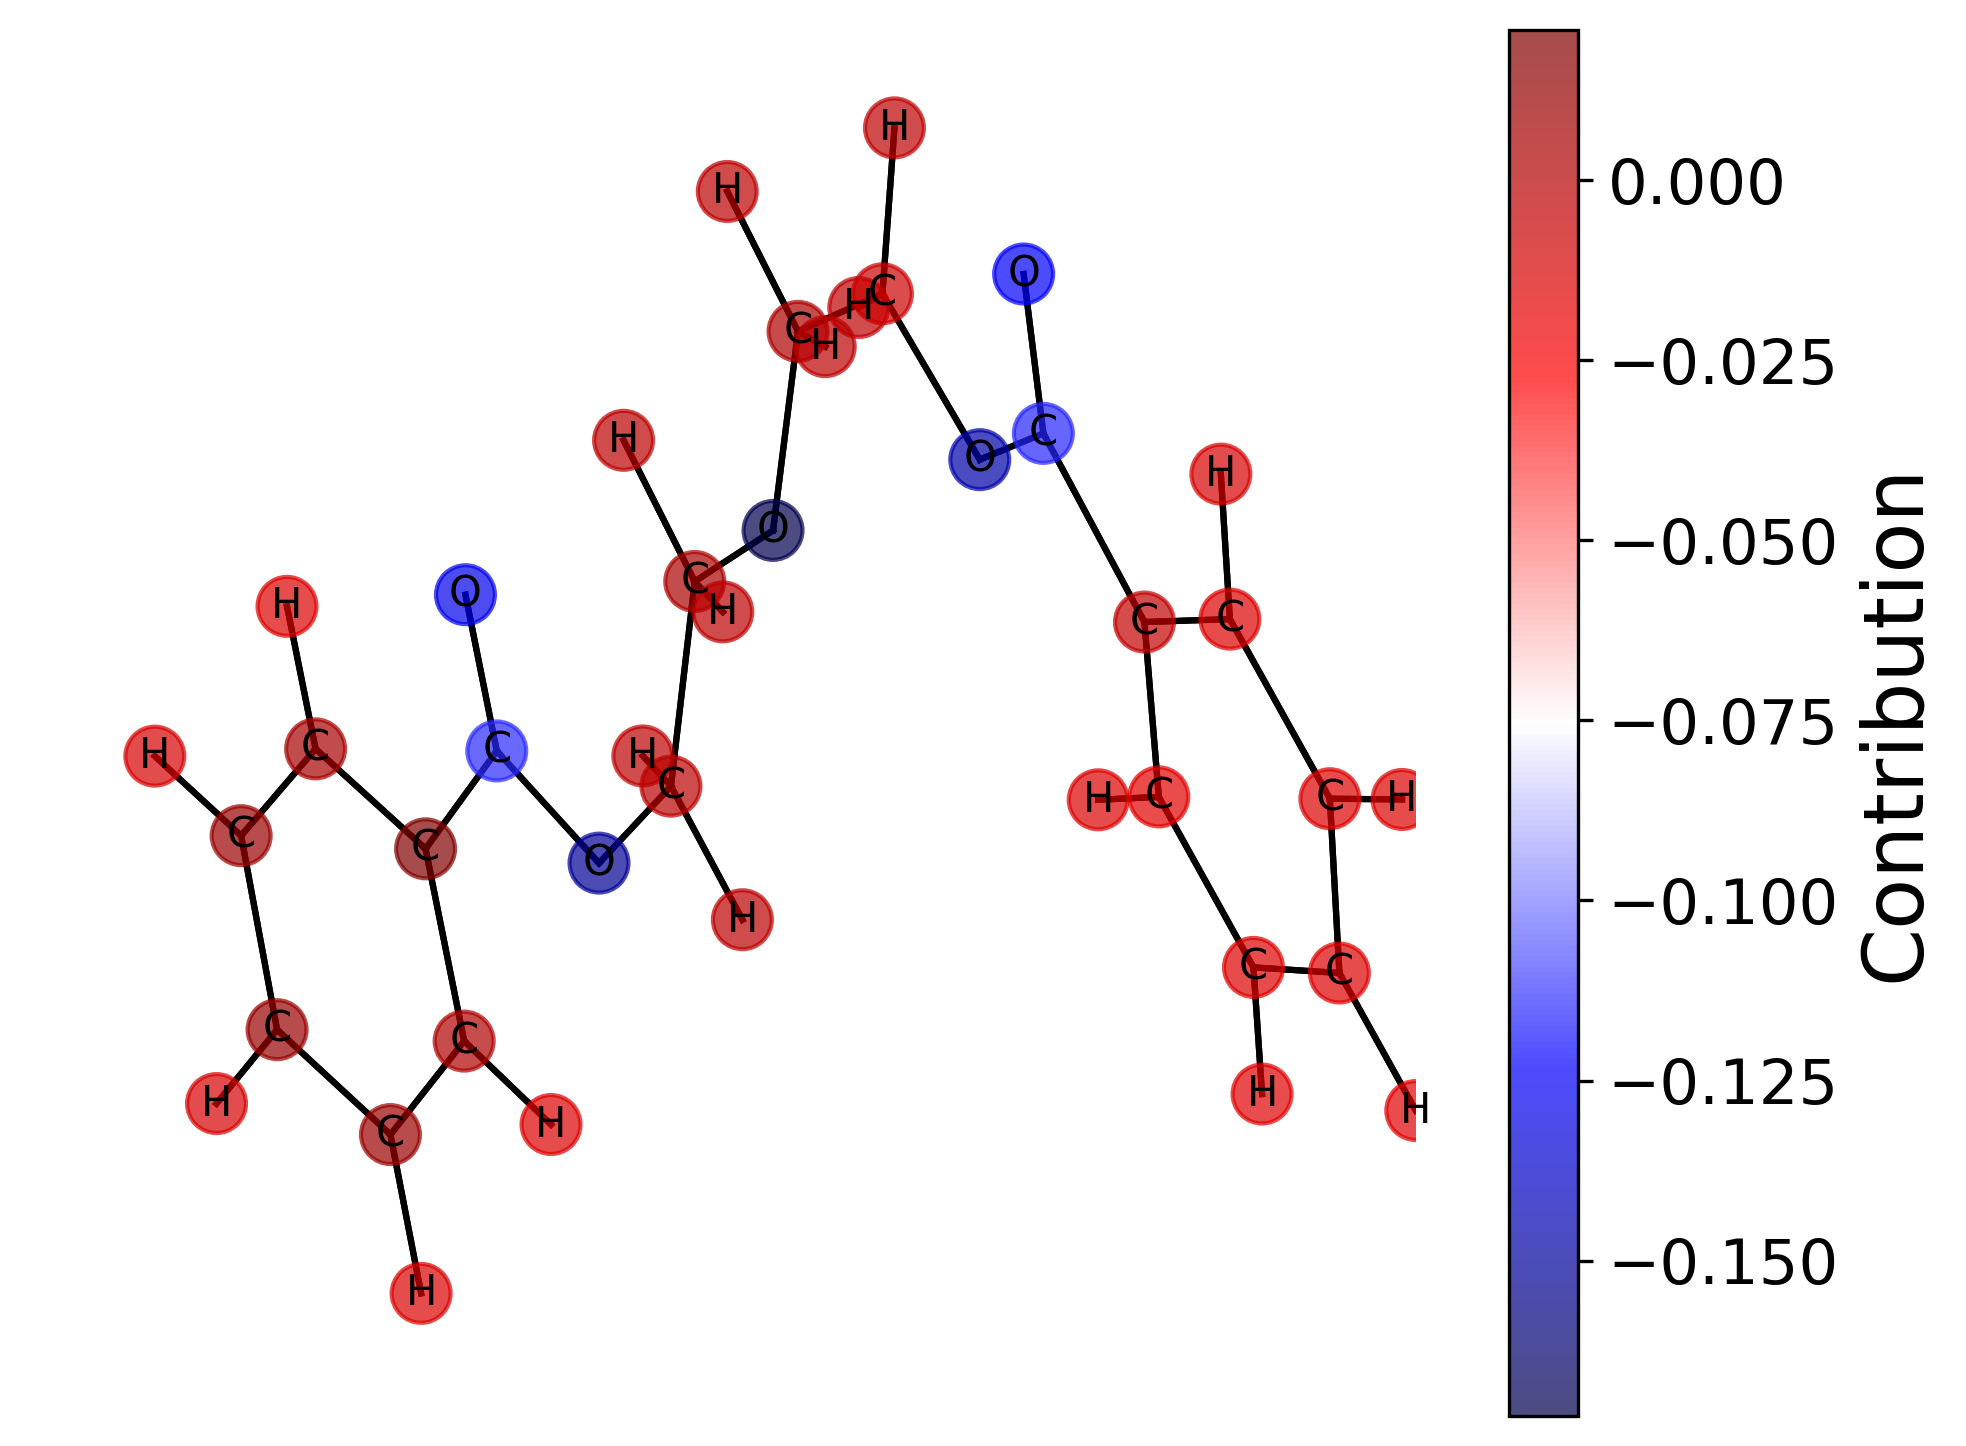

In [17]:
%matplotlib inline

fig, ax = plt.subplots(1, 1, figsize = (8, 6), dpi = 300,
                       subplot_kw = dict(projection = '3d'))

p = explainer.plot(ax)

ax.dist = 100

ax.view_init(azim = -100, elev = 73, roll = 0)
ax.set_box_aspect(None, zoom = 1.5)

cb = fig.colorbar(p)
cb.set_label("Contribution", fontsize = 20)
cb.ax.tick_params(labelsize = 15)

plt.savefig(f"./explain_results/{parameters['target']}_{SMILES}.png", dpi = 300)
plt.show()